# Objectives

- View the Liquidity provider token as derivative
- Compare that to a standard derivative 
- Understand why an LP might provide liquidity other than to simply earn fees

# Prerequisites

- Metamask
- Web3 python

# Interacting with GUI

We first obtain LP tokens for Uniswap v3 by depositing some liquidity to the TIGER/LUSD pool.

## Depositing liquidity

- Deposit liquidity for TIGER and LUSD into the Uniswap v3 pool [here](https://app.uniswap.org/pools)
- Connect your Metamask wallet
- Add a new position
- Put token 1 as TIGER (0x42d3F8B4a384e2D3d2f7cce4B986648771051D6F)
- Put token 2 as LUSD (0x62d92D8F8bad22F5f4d69dB24698F150cD637675)
- Select the 0.05% fee tier
- Set the price range from 0 to 100000000000000000000000
- Deposit 0.1 TIGER tokens. The LUSD amount will be set automatically according to the current price
- Preview and then submit the transaction
- Confirm it on Metamask and then view it on the block explorer. This confirms that you have deposited TIGER and LUSD tokens in the Uniswap v3 pool as an LP. You would be able to view your position on the Uniswap v3 website along with the fees collected over time.

# Derivatives and their payoff functions

Investing has grown more complicated in recent decades with the creation of numerous derivative instruments offering new ways to manage money. The use of derivatives to hedge risk or improve returns has been around for generations.

**Options** are the simplest derivative investment. Their value is tied to the value of the contract's underlying security. Options give a buyer the opportunity to buy or sell the underlying security. The investor does not own the underlying asset but they make a bet on the direction of its price movement.

The payoff function of an option shows the profit/loss obtained from an option depending on its market price.

There are many types of derivative instruments, including options, swaps, futures, and forward contracts. Derivatives have numerous uses and various levels of risks but are generally considered a sound way to participate in the financial markets.

## Example: call/put options

A call option is a type of option that gives the holder the right to buy the underlying asset at a specified price, known as the strike price, before the option expires. If the price of the underlying asset rises above the strike price, the holder can exercise the option and purchase the asset at the lower strike price, then sell it at the higher market price for a profit. If the price does not rise above the strike price, the holder can choose not to exercise the option and simply let it expire worthless. Its payoff function has been shown below.
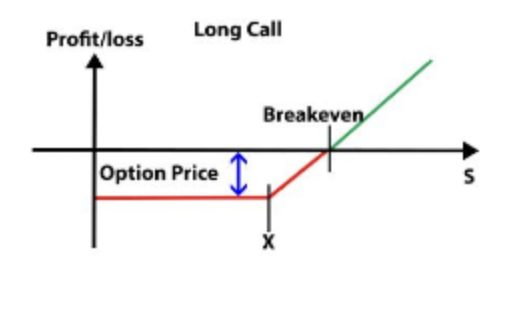

On the other hand, a put option is a type of option that gives the holder the right to sell the underlying asset at a specified price, before the option expires. If the price of the underlying asset falls below the strike price, the holder can exercise the option and sell the asset at the higher strike price, then buy it back at the lower market price for a profit. If the price does not fall below the strike price, the holder can choose not to exercise the option and simply let it expire worthless. In both cases, the holder pays a premium for the option contract, which is the price of the option, and if the option is not exercised, this premium represents a loss for the holder. Its payoff function has been shown below.
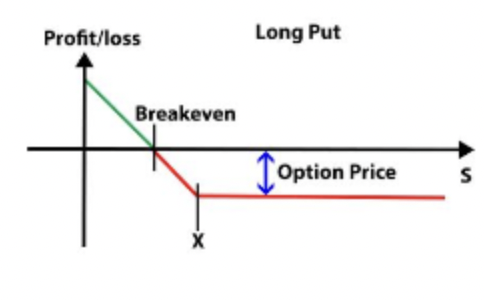

# What is the payoff function of an LP token?

In this lab, we look at an LP token as a derivative of the underlying token pairs and plot its payoff function.

## Connect to web3 API

In [ ]:
from web3 import Web3
import time
import matplotlib.pyplot as plt
from datetime import datetime, timedelta


w3 = Web3(Web3.HTTPProvider('https://sepolia.infura.io/v3/your-infura-key'))

print(w3.eth.get_block_number())

your_address = Web3.to_checksum_address('your-public-address')
your_private_key = 'your-private-key'

print(w3.__dict__)

## Identify the TIGER/LUSD pool

We now identify the TIGER/LUSD liquidity pool addresss through the Uniswap v3 factory contract

In [ ]:
factory_addr = Web3.to_checksum_address('0x0227628f3F023bb0B980b67D528571c95c6DaC1c')
abi_factory = '[{"inputs":[],"stateMutability":"nonpayable","type":"constructor"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"uint24","name":"fee","type":"uint24"},{"indexed":true,"internalType":"int24","name":"tickSpacing","type":"int24"}],"name":"FeeAmountEnabled","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"oldOwner","type":"address"},{"indexed":true,"internalType":"address","name":"newOwner","type":"address"}],"name":"OwnerChanged","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"token0","type":"address"},{"indexed":true,"internalType":"address","name":"token1","type":"address"},{"indexed":true,"internalType":"uint24","name":"fee","type":"uint24"},{"indexed":false,"internalType":"int24","name":"tickSpacing","type":"int24"},{"indexed":false,"internalType":"address","name":"pool","type":"address"}],"name":"PoolCreated","type":"event"},{"inputs":[{"internalType":"address","name":"tokenA","type":"address"},{"internalType":"address","name":"tokenB","type":"address"},{"internalType":"uint24","name":"fee","type":"uint24"}],"name":"createPool","outputs":[{"internalType":"address","name":"pool","type":"address"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint24","name":"fee","type":"uint24"},{"internalType":"int24","name":"tickSpacing","type":"int24"}],"name":"enableFeeAmount","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint24","name":"","type":"uint24"}],"name":"feeAmountTickSpacing","outputs":[{"internalType":"int24","name":"","type":"int24"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"","type":"address"},{"internalType":"address","name":"","type":"address"},{"internalType":"uint24","name":"","type":"uint24"}],"name":"getPool","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"owner","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"parameters","outputs":[{"internalType":"address","name":"factory","type":"address"},{"internalType":"address","name":"token0","type":"address"},{"internalType":"address","name":"token1","type":"address"},{"internalType":"uint24","name":"fee","type":"uint24"},{"internalType":"int24","name":"tickSpacing","type":"int24"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"_owner","type":"address"}],"name":"setOwner","outputs":[],"stateMutability":"nonpayable","type":"function"}]'
factory_contract = w3.eth.contract(factory_addr, abi=abi_factory)

tiger_token_address = Web3.to_checksum_address('0x42d3F8B4a384e2D3d2f7cce4B986648771051D6F')
lusd_token_address = Web3.to_checksum_address('0x62d92D8F8bad22F5f4d69dB24698F150cD637675')
abi_tiger = '[{"inputs":[],"stateMutability":"nonpayable","type":"constructor"},{"inputs":[{"internalType":"address","name":"spender","type":"address"},{"internalType":"uint256","name":"allowance","type":"uint256"},{"internalType":"uint256","name":"needed","type":"uint256"}],"name":"ERC20InsufficientAllowance","type":"error"},{"inputs":[{"internalType":"address","name":"sender","type":"address"},{"internalType":"uint256","name":"balance","type":"uint256"},{"internalType":"uint256","name":"needed","type":"uint256"}],"name":"ERC20InsufficientBalance","type":"error"},{"inputs":[{"internalType":"address","name":"approver","type":"address"}],"name":"ERC20InvalidApprover","type":"error"},{"inputs":[{"internalType":"address","name":"receiver","type":"address"}],"name":"ERC20InvalidReceiver","type":"error"},{"inputs":[{"internalType":"address","name":"sender","type":"address"}],"name":"ERC20InvalidSender","type":"error"},{"inputs":[{"internalType":"address","name":"spender","type":"address"}],"name":"ERC20InvalidSpender","type":"error"},{"inputs":[{"internalType":"address","name":"owner","type":"address"}],"name":"OwnableInvalidOwner","type":"error"},{"inputs":[{"internalType":"address","name":"account","type":"address"}],"name":"OwnableUnauthorizedAccount","type":"error"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"owner","type":"address"},{"indexed":true,"internalType":"address","name":"spender","type":"address"},{"indexed":false,"internalType":"uint256","name":"value","type":"uint256"}],"name":"Approval","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"previousOwner","type":"address"},{"indexed":true,"internalType":"address","name":"newOwner","type":"address"}],"name":"OwnershipTransferred","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"from","type":"address"},{"indexed":true,"internalType":"address","name":"to","type":"address"},{"indexed":false,"internalType":"uint256","name":"value","type":"uint256"}],"name":"Transfer","type":"event"},{"inputs":[{"internalType":"address","name":"owner","type":"address"},{"internalType":"address","name":"spender","type":"address"}],"name":"allowance","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"spender","type":"address"},{"internalType":"uint256","name":"value","type":"uint256"}],"name":"approve","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"account","type":"address"}],"name":"balanceOf","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"decimals","outputs":[{"internalType":"uint8","name":"","type":"uint8"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"to","type":"address"},{"internalType":"uint256","name":"amount","type":"uint256"}],"name":"mint","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"name","outputs":[{"internalType":"string","name":"","type":"string"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"owner","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"renounceOwnership","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"symbol","outputs":[{"internalType":"string","name":"","type":"string"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"totalSupply","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"to","type":"address"},{"internalType":"uint256","name":"value","type":"uint256"}],"name":"transfer","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"from","type":"address"},{"internalType":"address","name":"to","type":"address"},{"internalType":"uint256","name":"value","type":"uint256"}],"name":"transferFrom","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"newOwner","type":"address"}],"name":"transferOwnership","outputs":[],"stateMutability":"nonpayable","type":"function"}]'
abi_lusd = '[{"inputs":[],"stateMutability":"nonpayable","type":"constructor"},{"inputs":[{"internalType":"address","name":"spender","type":"address"},{"internalType":"uint256","name":"allowance","type":"uint256"},{"internalType":"uint256","name":"needed","type":"uint256"}],"name":"ERC20InsufficientAllowance","type":"error"},{"inputs":[{"internalType":"address","name":"sender","type":"address"},{"internalType":"uint256","name":"balance","type":"uint256"},{"internalType":"uint256","name":"needed","type":"uint256"}],"name":"ERC20InsufficientBalance","type":"error"},{"inputs":[{"internalType":"address","name":"approver","type":"address"}],"name":"ERC20InvalidApprover","type":"error"},{"inputs":[{"internalType":"address","name":"receiver","type":"address"}],"name":"ERC20InvalidReceiver","type":"error"},{"inputs":[{"internalType":"address","name":"sender","type":"address"}],"name":"ERC20InvalidSender","type":"error"},{"inputs":[{"internalType":"address","name":"spender","type":"address"}],"name":"ERC20InvalidSpender","type":"error"},{"inputs":[{"internalType":"address","name":"owner","type":"address"}],"name":"OwnableInvalidOwner","type":"error"},{"inputs":[{"internalType":"address","name":"account","type":"address"}],"name":"OwnableUnauthorizedAccount","type":"error"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"owner","type":"address"},{"indexed":true,"internalType":"address","name":"spender","type":"address"},{"indexed":false,"internalType":"uint256","name":"value","type":"uint256"}],"name":"Approval","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"previousOwner","type":"address"},{"indexed":true,"internalType":"address","name":"newOwner","type":"address"}],"name":"OwnershipTransferred","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"from","type":"address"},{"indexed":true,"internalType":"address","name":"to","type":"address"},{"indexed":false,"internalType":"uint256","name":"value","type":"uint256"}],"name":"Transfer","type":"event"},{"inputs":[{"internalType":"address","name":"owner","type":"address"},{"internalType":"address","name":"spender","type":"address"}],"name":"allowance","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"spender","type":"address"},{"internalType":"uint256","name":"value","type":"uint256"}],"name":"approve","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"account","type":"address"}],"name":"balanceOf","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"decimals","outputs":[{"internalType":"uint8","name":"","type":"uint8"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"to","type":"address"},{"internalType":"uint256","name":"amount","type":"uint256"}],"name":"mint","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"name","outputs":[{"internalType":"string","name":"","type":"string"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"owner","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"renounceOwnership","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"symbol","outputs":[{"internalType":"string","name":"","type":"string"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"totalSupply","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"to","type":"address"},{"internalType":"uint256","name":"value","type":"uint256"}],"name":"transfer","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"from","type":"address"},{"internalType":"address","name":"to","type":"address"},{"internalType":"uint256","name":"value","type":"uint256"}],"name":"transferFrom","outputs":[{"internalType":"bool","name":"","type":"bool"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"newOwner","type":"address"}],"name":"transferOwnership","outputs":[],"stateMutability":"nonpayable","type":"function"}]'

def get_pool_address(tokenA, tokenB, fee,factory_contract):
    # Ensure tokens are in correct order (Uniswap V3 requires sorted token addresses)
    if tokenA > tokenB:
        tokenA, tokenB = tokenB, tokenA

    # Call the getPool function
    pool_address = factory_contract.functions.getPool(tokenA, tokenB, fee).call()
    return pool_address

tiger_lusd_pool_address = get_pool_address(lusd_token_address,tiger_token_address,500,factory_contract)
abi_pool = '[{"inputs":[],"stateMutability":"nonpayable","type":"constructor"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"owner","type":"address"},{"indexed":true,"internalType":"int24","name":"tickLower","type":"int24"},{"indexed":true,"internalType":"int24","name":"tickUpper","type":"int24"},{"indexed":false,"internalType":"uint128","name":"amount","type":"uint128"},{"indexed":false,"internalType":"uint256","name":"amount0","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"amount1","type":"uint256"}],"name":"Burn","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"owner","type":"address"},{"indexed":false,"internalType":"address","name":"recipient","type":"address"},{"indexed":true,"internalType":"int24","name":"tickLower","type":"int24"},{"indexed":true,"internalType":"int24","name":"tickUpper","type":"int24"},{"indexed":false,"internalType":"uint128","name":"amount0","type":"uint128"},{"indexed":false,"internalType":"uint128","name":"amount1","type":"uint128"}],"name":"Collect","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"sender","type":"address"},{"indexed":true,"internalType":"address","name":"recipient","type":"address"},{"indexed":false,"internalType":"uint128","name":"amount0","type":"uint128"},{"indexed":false,"internalType":"uint128","name":"amount1","type":"uint128"}],"name":"CollectProtocol","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"sender","type":"address"},{"indexed":true,"internalType":"address","name":"recipient","type":"address"},{"indexed":false,"internalType":"uint256","name":"amount0","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"amount1","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"paid0","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"paid1","type":"uint256"}],"name":"Flash","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"uint16","name":"observationCardinalityNextOld","type":"uint16"},{"indexed":false,"internalType":"uint16","name":"observationCardinalityNextNew","type":"uint16"}],"name":"IncreaseObservationCardinalityNext","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"uint160","name":"sqrtPriceX96","type":"uint160"},{"indexed":false,"internalType":"int24","name":"tick","type":"int24"}],"name":"Initialize","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"address","name":"sender","type":"address"},{"indexed":true,"internalType":"address","name":"owner","type":"address"},{"indexed":true,"internalType":"int24","name":"tickLower","type":"int24"},{"indexed":true,"internalType":"int24","name":"tickUpper","type":"int24"},{"indexed":false,"internalType":"uint128","name":"amount","type":"uint128"},{"indexed":false,"internalType":"uint256","name":"amount0","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"amount1","type":"uint256"}],"name":"Mint","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"uint8","name":"feeProtocol0Old","type":"uint8"},{"indexed":false,"internalType":"uint8","name":"feeProtocol1Old","type":"uint8"},{"indexed":false,"internalType":"uint8","name":"feeProtocol0New","type":"uint8"},{"indexed":false,"internalType":"uint8","name":"feeProtocol1New","type":"uint8"}],"name":"SetFeeProtocol","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"sender","type":"address"},{"indexed":true,"internalType":"address","name":"recipient","type":"address"},{"indexed":false,"internalType":"int256","name":"amount0","type":"int256"},{"indexed":false,"internalType":"int256","name":"amount1","type":"int256"},{"indexed":false,"internalType":"uint160","name":"sqrtPriceX96","type":"uint160"},{"indexed":false,"internalType":"uint128","name":"liquidity","type":"uint128"},{"indexed":false,"internalType":"int24","name":"tick","type":"int24"}],"name":"Swap","type":"event"},{"inputs":[{"internalType":"int24","name":"tickLower","type":"int24"},{"internalType":"int24","name":"tickUpper","type":"int24"},{"internalType":"uint128","name":"amount","type":"uint128"}],"name":"burn","outputs":[{"internalType":"uint256","name":"amount0","type":"uint256"},{"internalType":"uint256","name":"amount1","type":"uint256"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"recipient","type":"address"},{"internalType":"int24","name":"tickLower","type":"int24"},{"internalType":"int24","name":"tickUpper","type":"int24"},{"internalType":"uint128","name":"amount0Requested","type":"uint128"},{"internalType":"uint128","name":"amount1Requested","type":"uint128"}],"name":"collect","outputs":[{"internalType":"uint128","name":"amount0","type":"uint128"},{"internalType":"uint128","name":"amount1","type":"uint128"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"recipient","type":"address"},{"internalType":"uint128","name":"amount0Requested","type":"uint128"},{"internalType":"uint128","name":"amount1Requested","type":"uint128"}],"name":"collectProtocol","outputs":[{"internalType":"uint128","name":"amount0","type":"uint128"},{"internalType":"uint128","name":"amount1","type":"uint128"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"factory","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"fee","outputs":[{"internalType":"uint24","name":"","type":"uint24"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"feeGrowthGlobal0X128","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"feeGrowthGlobal1X128","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"recipient","type":"address"},{"internalType":"uint256","name":"amount0","type":"uint256"},{"internalType":"uint256","name":"amount1","type":"uint256"},{"internalType":"bytes","name":"data","type":"bytes"}],"name":"flash","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint16","name":"observationCardinalityNext","type":"uint16"}],"name":"increaseObservationCardinalityNext","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint160","name":"sqrtPriceX96","type":"uint160"}],"name":"initialize","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"liquidity","outputs":[{"internalType":"uint128","name":"","type":"uint128"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"maxLiquidityPerTick","outputs":[{"internalType":"uint128","name":"","type":"uint128"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"recipient","type":"address"},{"internalType":"int24","name":"tickLower","type":"int24"},{"internalType":"int24","name":"tickUpper","type":"int24"},{"internalType":"uint128","name":"amount","type":"uint128"},{"internalType":"bytes","name":"data","type":"bytes"}],"name":"mint","outputs":[{"internalType":"uint256","name":"amount0","type":"uint256"},{"internalType":"uint256","name":"amount1","type":"uint256"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"","type":"uint256"}],"name":"observations","outputs":[{"internalType":"uint32","name":"blockTimestamp","type":"uint32"},{"internalType":"int56","name":"tickCumulative","type":"int56"},{"internalType":"uint160","name":"secondsPerLiquidityCumulativeX128","type":"uint160"},{"internalType":"bool","name":"initialized","type":"bool"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint32[]","name":"secondsAgos","type":"uint32[]"}],"name":"observe","outputs":[{"internalType":"int56[]","name":"tickCumulatives","type":"int56[]"},{"internalType":"uint160[]","name":"secondsPerLiquidityCumulativeX128s","type":"uint160[]"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"bytes32","name":"","type":"bytes32"}],"name":"positions","outputs":[{"internalType":"uint128","name":"liquidity","type":"uint128"},{"internalType":"uint256","name":"feeGrowthInside0LastX128","type":"uint256"},{"internalType":"uint256","name":"feeGrowthInside1LastX128","type":"uint256"},{"internalType":"uint128","name":"tokensOwed0","type":"uint128"},{"internalType":"uint128","name":"tokensOwed1","type":"uint128"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"protocolFees","outputs":[{"internalType":"uint128","name":"token0","type":"uint128"},{"internalType":"uint128","name":"token1","type":"uint128"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint8","name":"feeProtocol0","type":"uint8"},{"internalType":"uint8","name":"feeProtocol1","type":"uint8"}],"name":"setFeeProtocol","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"slot0","outputs":[{"internalType":"uint160","name":"sqrtPriceX96","type":"uint160"},{"internalType":"int24","name":"tick","type":"int24"},{"internalType":"uint16","name":"observationIndex","type":"uint16"},{"internalType":"uint16","name":"observationCardinality","type":"uint16"},{"internalType":"uint16","name":"observationCardinalityNext","type":"uint16"},{"internalType":"uint8","name":"feeProtocol","type":"uint8"},{"internalType":"bool","name":"unlocked","type":"bool"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"int24","name":"tickLower","type":"int24"},{"internalType":"int24","name":"tickUpper","type":"int24"}],"name":"snapshotCumulativesInside","outputs":[{"internalType":"int56","name":"tickCumulativeInside","type":"int56"},{"internalType":"uint160","name":"secondsPerLiquidityInsideX128","type":"uint160"},{"internalType":"uint32","name":"secondsInside","type":"uint32"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"recipient","type":"address"},{"internalType":"bool","name":"zeroForOne","type":"bool"},{"internalType":"int256","name":"amountSpecified","type":"int256"},{"internalType":"uint160","name":"sqrtPriceLimitX96","type":"uint160"},{"internalType":"bytes","name":"data","type":"bytes"}],"name":"swap","outputs":[{"internalType":"int256","name":"amount0","type":"int256"},{"internalType":"int256","name":"amount1","type":"int256"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"int16","name":"","type":"int16"}],"name":"tickBitmap","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"tickSpacing","outputs":[{"internalType":"int24","name":"","type":"int24"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"int24","name":"","type":"int24"}],"name":"ticks","outputs":[{"internalType":"uint128","name":"liquidityGross","type":"uint128"},{"internalType":"int128","name":"liquidityNet","type":"int128"},{"internalType":"uint256","name":"feeGrowthOutside0X128","type":"uint256"},{"internalType":"uint256","name":"feeGrowthOutside1X128","type":"uint256"},{"internalType":"int56","name":"tickCumulativeOutside","type":"int56"},{"internalType":"uint160","name":"secondsPerLiquidityOutsideX128","type":"uint160"},{"internalType":"uint32","name":"secondsOutside","type":"uint32"},{"internalType":"bool","name":"initialized","type":"bool"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"token0","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"token1","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"}]'

print(tiger_lusd_pool_address)

## Obtain LP Payoffs in LUSD

First we obtain our balance of Uniswap v3 LP tokens for the pool we deposited liquidity to.

In [ ]:
pool_address = Web3.to_checksum_address('pool-address-here')
pool_abi = '[{"inputs":[],"stateMutability":"nonpayable","type":"constructor"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"owner","type":"address"},{"indexed":true,"internalType":"int24","name":"tickLower","type":"int24"},{"indexed":true,"internalType":"int24","name":"tickUpper","type":"int24"},{"indexed":false,"internalType":"uint128","name":"amount","type":"uint128"},{"indexed":false,"internalType":"uint256","name":"amount0","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"amount1","type":"uint256"}],"name":"Burn","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"owner","type":"address"},{"indexed":false,"internalType":"address","name":"recipient","type":"address"},{"indexed":true,"internalType":"int24","name":"tickLower","type":"int24"},{"indexed":true,"internalType":"int24","name":"tickUpper","type":"int24"},{"indexed":false,"internalType":"uint128","name":"amount0","type":"uint128"},{"indexed":false,"internalType":"uint128","name":"amount1","type":"uint128"}],"name":"Collect","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"sender","type":"address"},{"indexed":true,"internalType":"address","name":"recipient","type":"address"},{"indexed":false,"internalType":"uint128","name":"amount0","type":"uint128"},{"indexed":false,"internalType":"uint128","name":"amount1","type":"uint128"}],"name":"CollectProtocol","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"sender","type":"address"},{"indexed":true,"internalType":"address","name":"recipient","type":"address"},{"indexed":false,"internalType":"uint256","name":"amount0","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"amount1","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"paid0","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"paid1","type":"uint256"}],"name":"Flash","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"uint16","name":"observationCardinalityNextOld","type":"uint16"},{"indexed":false,"internalType":"uint16","name":"observationCardinalityNextNew","type":"uint16"}],"name":"IncreaseObservationCardinalityNext","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"uint160","name":"sqrtPriceX96","type":"uint160"},{"indexed":false,"internalType":"int24","name":"tick","type":"int24"}],"name":"Initialize","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"address","name":"sender","type":"address"},{"indexed":true,"internalType":"address","name":"owner","type":"address"},{"indexed":true,"internalType":"int24","name":"tickLower","type":"int24"},{"indexed":true,"internalType":"int24","name":"tickUpper","type":"int24"},{"indexed":false,"internalType":"uint128","name":"amount","type":"uint128"},{"indexed":false,"internalType":"uint256","name":"amount0","type":"uint256"},{"indexed":false,"internalType":"uint256","name":"amount1","type":"uint256"}],"name":"Mint","type":"event"},{"anonymous":false,"inputs":[{"indexed":false,"internalType":"uint8","name":"feeProtocol0Old","type":"uint8"},{"indexed":false,"internalType":"uint8","name":"feeProtocol1Old","type":"uint8"},{"indexed":false,"internalType":"uint8","name":"feeProtocol0New","type":"uint8"},{"indexed":false,"internalType":"uint8","name":"feeProtocol1New","type":"uint8"}],"name":"SetFeeProtocol","type":"event"},{"anonymous":false,"inputs":[{"indexed":true,"internalType":"address","name":"sender","type":"address"},{"indexed":true,"internalType":"address","name":"recipient","type":"address"},{"indexed":false,"internalType":"int256","name":"amount0","type":"int256"},{"indexed":false,"internalType":"int256","name":"amount1","type":"int256"},{"indexed":false,"internalType":"uint160","name":"sqrtPriceX96","type":"uint160"},{"indexed":false,"internalType":"uint128","name":"liquidity","type":"uint128"},{"indexed":false,"internalType":"int24","name":"tick","type":"int24"}],"name":"Swap","type":"event"},{"inputs":[{"internalType":"int24","name":"tickLower","type":"int24"},{"internalType":"int24","name":"tickUpper","type":"int24"},{"internalType":"uint128","name":"amount","type":"uint128"}],"name":"burn","outputs":[{"internalType":"uint256","name":"amount0","type":"uint256"},{"internalType":"uint256","name":"amount1","type":"uint256"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"recipient","type":"address"},{"internalType":"int24","name":"tickLower","type":"int24"},{"internalType":"int24","name":"tickUpper","type":"int24"},{"internalType":"uint128","name":"amount0Requested","type":"uint128"},{"internalType":"uint128","name":"amount1Requested","type":"uint128"}],"name":"collect","outputs":[{"internalType":"uint128","name":"amount0","type":"uint128"},{"internalType":"uint128","name":"amount1","type":"uint128"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"address","name":"recipient","type":"address"},{"internalType":"uint128","name":"amount0Requested","type":"uint128"},{"internalType":"uint128","name":"amount1Requested","type":"uint128"}],"name":"collectProtocol","outputs":[{"internalType":"uint128","name":"amount0","type":"uint128"},{"internalType":"uint128","name":"amount1","type":"uint128"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"factory","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"fee","outputs":[{"internalType":"uint24","name":"","type":"uint24"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"feeGrowthGlobal0X128","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"feeGrowthGlobal1X128","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"recipient","type":"address"},{"internalType":"uint256","name":"amount0","type":"uint256"},{"internalType":"uint256","name":"amount1","type":"uint256"},{"internalType":"bytes","name":"data","type":"bytes"}],"name":"flash","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint16","name":"observationCardinalityNext","type":"uint16"}],"name":"increaseObservationCardinalityNext","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint160","name":"sqrtPriceX96","type":"uint160"}],"name":"initialize","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"liquidity","outputs":[{"internalType":"uint128","name":"","type":"uint128"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"maxLiquidityPerTick","outputs":[{"internalType":"uint128","name":"","type":"uint128"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"recipient","type":"address"},{"internalType":"int24","name":"tickLower","type":"int24"},{"internalType":"int24","name":"tickUpper","type":"int24"},{"internalType":"uint128","name":"amount","type":"uint128"},{"internalType":"bytes","name":"data","type":"bytes"}],"name":"mint","outputs":[{"internalType":"uint256","name":"amount0","type":"uint256"},{"internalType":"uint256","name":"amount1","type":"uint256"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"uint256","name":"","type":"uint256"}],"name":"observations","outputs":[{"internalType":"uint32","name":"blockTimestamp","type":"uint32"},{"internalType":"int56","name":"tickCumulative","type":"int56"},{"internalType":"uint160","name":"secondsPerLiquidityCumulativeX128","type":"uint160"},{"internalType":"bool","name":"initialized","type":"bool"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint32[]","name":"secondsAgos","type":"uint32[]"}],"name":"observe","outputs":[{"internalType":"int56[]","name":"tickCumulatives","type":"int56[]"},{"internalType":"uint160[]","name":"secondsPerLiquidityCumulativeX128s","type":"uint160[]"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"bytes32","name":"","type":"bytes32"}],"name":"positions","outputs":[{"internalType":"uint128","name":"liquidity","type":"uint128"},{"internalType":"uint256","name":"feeGrowthInside0LastX128","type":"uint256"},{"internalType":"uint256","name":"feeGrowthInside1LastX128","type":"uint256"},{"internalType":"uint128","name":"tokensOwed0","type":"uint128"},{"internalType":"uint128","name":"tokensOwed1","type":"uint128"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"protocolFees","outputs":[{"internalType":"uint128","name":"token0","type":"uint128"},{"internalType":"uint128","name":"token1","type":"uint128"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"uint8","name":"feeProtocol0","type":"uint8"},{"internalType":"uint8","name":"feeProtocol1","type":"uint8"}],"name":"setFeeProtocol","outputs":[],"stateMutability":"nonpayable","type":"function"},{"inputs":[],"name":"slot0","outputs":[{"internalType":"uint160","name":"sqrtPriceX96","type":"uint160"},{"internalType":"int24","name":"tick","type":"int24"},{"internalType":"uint16","name":"observationIndex","type":"uint16"},{"internalType":"uint16","name":"observationCardinality","type":"uint16"},{"internalType":"uint16","name":"observationCardinalityNext","type":"uint16"},{"internalType":"uint8","name":"feeProtocol","type":"uint8"},{"internalType":"bool","name":"unlocked","type":"bool"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"int24","name":"tickLower","type":"int24"},{"internalType":"int24","name":"tickUpper","type":"int24"}],"name":"snapshotCumulativesInside","outputs":[{"internalType":"int56","name":"tickCumulativeInside","type":"int56"},{"internalType":"uint160","name":"secondsPerLiquidityInsideX128","type":"uint160"},{"internalType":"uint32","name":"secondsInside","type":"uint32"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"address","name":"recipient","type":"address"},{"internalType":"bool","name":"zeroForOne","type":"bool"},{"internalType":"int256","name":"amountSpecified","type":"int256"},{"internalType":"uint160","name":"sqrtPriceLimitX96","type":"uint160"},{"internalType":"bytes","name":"data","type":"bytes"}],"name":"swap","outputs":[{"internalType":"int256","name":"amount0","type":"int256"},{"internalType":"int256","name":"amount1","type":"int256"}],"stateMutability":"nonpayable","type":"function"},{"inputs":[{"internalType":"int16","name":"","type":"int16"}],"name":"tickBitmap","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"tickSpacing","outputs":[{"internalType":"int24","name":"","type":"int24"}],"stateMutability":"view","type":"function"},{"inputs":[{"internalType":"int24","name":"","type":"int24"}],"name":"ticks","outputs":[{"internalType":"uint128","name":"liquidityGross","type":"uint128"},{"internalType":"int128","name":"liquidityNet","type":"int128"},{"internalType":"uint256","name":"feeGrowthOutside0X128","type":"uint256"},{"internalType":"uint256","name":"feeGrowthOutside1X128","type":"uint256"},{"internalType":"int56","name":"tickCumulativeOutside","type":"int56"},{"internalType":"uint160","name":"secondsPerLiquidityOutsideX128","type":"uint160"},{"internalType":"uint32","name":"secondsOutside","type":"uint32"},{"internalType":"bool","name":"initialized","type":"bool"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"token0","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"},{"inputs":[],"name":"token1","outputs":[{"internalType":"address","name":"","type":"address"}],"stateMutability":"view","type":"function"}]'
univ3_token_contract = w3.eth.contract(address=pool_address, abi=pool_abi)
current_price = univ3_token_contract.functions.slot0().call()[0]**2 / 2**192
print("Price of TIGER right now : ",current_price)

Now, we write a function that calculates the payoff of the LP token you have. This is same as anwering the following question : how much wealth in USD will I get back if I withdraw my liquidity position at the current price?

In [ ]:
def getLPpayoff():
    tiger_contract = w3.eth.contract(tiger_token_address, abi=abi_tiger)
    lusd_contract = w3.eth.contract(lusd_token_address, abi=abi_lusd)
    
    tiger_reserve = (tiger_contract.functions.balanceOf(pool_address).call())/10**18
    lusd_reserve = (lusd_contract.functions.balanceOf(pool_address).call())/10**18
    tiger_price = lusd_reserve/tiger_reserve
    
    payoff = ???? # fill this in 

    payoff = 0.0000001 * payoff # assuming each student has a small part of reserves
    return tiger_price, payoff, lusd_reserve, tiger_reserve

print(getLPpayoff())

## Calculate LP token payoffs

We now calculate LP payoffs for a range of prices. To do that, the TA will manipulate the pool price by doing large swaps.

In [ ]:
# Perform high-impact swaps in iterations and calculate LP payoffs
iterations = 10
iter = 0
tiger_prices = []
lusd_payoffs = []

You would have to run the following cell once after EACH time the pool price is manipulated and the transaction is confirmed. The TA's address is 0xB737D25859AD77848363cb2d2DD3DA496B91b4BF. You can reload the account activity to see when a new transaction is confirmed.

In [ ]:
(tiger_price, lusd_payoff, lusd, tiger) = getLPpayoff()
print("TIGER price: ", tiger_price, "USD payoff: ", lusd_payoff)
print("TIGER reserves: ", tiger, "LUSD reserves: ", lusd)
tiger_prices.append(tiger_price)
lusd_payoffs.append(lusd_payoff)
iter += 1

In [ ]:
# draw the plot
plt.figure(figsize=(10, 6))
plt.plot(tiger_prices, lusd_payoffs, 'ro')
plt.xlabel('TIGER price in USD')
plt.ylabel('LP payoff in USD')
plt.title('Calculate LP token payoff')
plt.grid(True)
plt.show()

# Replicating market makers

Turns out you can generate a rich family of payoffs using a CFMM. In fact there is a one-to-one mapping between concave payoffs and CFMM bonding curves! Convex payoffs can be obtained by shorting an LP token.

If anyone is interested to know this mapping and how it is obtained, see [this paper](https://arxiv.org/pdf/2103.14769.pdf). 